In [1]:
import os,sys,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import h5py
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import copy
import pdb
import time
from tqdm.notebook import trange, tqdm
from ipywidgets import interact, IntSlider, Layout

from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

from datetime import datetime

_dtype_ = torch.float32
_device_ = torch.device('mps')

# seq_len = 1
# seq_len_forward = 1
metrics = {}

class PP_MLP(nn.Module): # Price Pridiction

    def __init__(self, seq_len_f):

        super(PP_MLP, self).__init__() 
        self.layer1 = nn.Linear(14, 20)  
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.output = nn.Linear(20, seq_len_f)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        x = self.relu(self.layer1(x)) 
        x = self.relu(self.layer2(x)) 
        x = self.relu(self.layer3(x)) 
        return self.output(x) 
    
class PP_LSTM(nn.Module):
    def __init__(self, seq_len_f):

        super(PP_LSTM, self).__init__()
        self.hidden_dim = 20
        self.lstm = nn.LSTM(14, self.hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.dense_1 = nn.Linear(self.hidden_dim, 20)
        self.dense_2 = nn.Linear(20, 20)
        self.dense_3 = nn.Linear(20, seq_len_f)
        self.relu = nn.ReLU()

    def forward(self, x):

        lstm_out, _ = self.lstm(x)
        
        x = lstm_out[:, -1, :]
        x = self.dropout(x) 
        x = self.relu(self.dense_1(x))
        x = self.relu(self.dense_2(x))
        x = self.dense_3(x)
        
        return x
    
class PP_LSTMSeq2Seq(nn.Module):
    def __init__(self):

        super(PP_LSTMSeq2Seq, self).__init__()

        emb_size = 64

        self.embedding_encoder = nn.Linear(14, emb_size)
        self.embedding_decoder = nn.Linear(1, emb_size)

        self.mlp_emb = nn.Sequential(
            nn.Linear(emb_size, emb_size),
            nn.LayerNorm(emb_size),
            nn.ELU(),
            nn.Linear(emb_size, emb_size)
        )

        self.hidden_dim = 20

        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=self.hidden_dim,
            num_layers=2,
            batch_first=True,
            dropout=0.25
        )

        self.dense_1 = nn.Linear(self.hidden_dim, 10)
        self.dense_2 = nn.Linear(10, 5)
        self.dense_3 = nn.Linear(5, 1)
        self.relu = nn.ReLU()

    def forward(self, x):

        if x.shape[-1] == 1:
            x = self.embedding_decoder(x)
        else:
            x = self.embedding_encoder(x)
        
        x = self.mlp_emb(x)

        lstm_out, _ = self.lstm(x)

        x = lstm_out#[:, -1, :]
        x = self.relu(self.dense_1(x))
        x = self.relu(self.dense_2(x))
        x = self.dense_3(x)
        
        return x

# Components of transformer

class SinPosEncoding(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim

    def forward(self, x):
        device = x.device
        half_dim = self.emb_dim // 2
        pos_emb = np.log(10000) / (half_dim - 1)
        pos_emb = torch.exp(torch.arange(half_dim, device = device) * (- pos_emb))
        pos_emb = x[:, None] * pos_emb[None, :]
        pos_emb = torch.cat((pos_emb.sin(), pos_emb.cos()), dim = -1)
        return pos_emb
    
class AttentionLayer(nn.Module):
    def __init__(self, 
                 hidden_size = 64, 
                 num_heads = 4, 
                 masking = True):
        
        super().__init__()
        self.masking = masking
        self.mh_attn = nn.MultiheadAttention(hidden_size,
                                             num_heads = num_heads,
                                             batch_first = True,
                                             dropout = 0.25)

    def forward(self, 
                x_in, 
                kv_in, 
                key_mask = None):
        
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None

        return self.mh_attn(x_in, 
                            kv_in, 
                            kv_in, 
                            attn_mask = mask, 
                            key_padding_mask = key_mask)[0]

class CoreLayer(nn.Module):
    def __init__(self, 
                 hidden_size = 64, 
                 num_heads = 4, 
                 block_type = 'encoder', 
                 masking = True):
        super().__init__()
        self.block_type = block_type

        self.layer_norm_1 = nn.LayerNorm(hidden_size)

        self.attn_1 = AttentionLayer(hidden_size = hidden_size, 
                                     num_heads = num_heads, 
                                     masking = masking)
        
        if self.block_type == 'decoder':
            self.layer_norm_2 = nn.LayerNorm(hidden_size)
            self.attn_2 = AttentionLayer(hidden_size = hidden_size, 
                                         num_heads = num_heads, 
                                         masking = False)
        
        self.layer_norm_mlp = nn.LayerNorm(hidden_size)

        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
                
    def forward(self,
                x, 
                input_key_mask = None, 
                cross_key_mask = None, 
                kv_cross = None):

        x = self.attn_1(x, x, key_mask = input_key_mask) + x
        x = self.layer_norm_1(x)

        if self.block_type == 'decoder':
            x = self.attn_2(x, kv_cross, key_mask = cross_key_mask) + x
            x = self.layer_norm_2(x)

        x = self.mlp(x) + x
        return self.layer_norm_mlp(x)

class Encoder(nn.Module):
    def __init__(self, 
                 dim_i, 
                 hidden_size = 64, 
                 num_layers = 2, 
                 num_heads = 4):
        super().__init__()

        self.embedding = nn.Linear(dim_i, hidden_size)
        # Instantiate the positional encoding
        self.pos_encoding = SinPosEncoding(hidden_size)

        self.core_layer = nn.ModuleList([
            CoreLayer(hidden_size, 
                      num_heads, 
                      'encoder', 
                      masking = False) for _ in range(num_layers)
        ])
                
    def forward(self, 
                input_seq, 
                padding_mask = None):        
        
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        indices = torch.arange(l, device = input_seq.device)
        pos_encoding = self.pos_encoding(indices).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_encoding
        
        for layer in self.core_layer:
            embs = layer(embs, 
                         input_key_mask = padding_mask)
        
        return embs
    
class Decoder(nn.Module):
    def __init__(self, 
                 dim_o, 
                 hidden_size = 64, 
                 num_layers = 2, 
                 num_heads = 4,
                 categorical = False):
        super().__init__()

        if categorical:
            self.embedding = nn.Embedding(dim_o, hidden_size)
            self.embedding.weight.data = 0.001 * self.embedding.weight.data
        else:
            self.embedding = nn.Linear(dim_o, hidden_size)

        self.pos_encoding = SinPosEncoding(hidden_size)
        
        self.core_layer = nn.ModuleList([
            CoreLayer(hidden_size, 
                      num_heads, 
                      'decoder', 
                      masking = True) for _ in range(num_layers)
        ])
                
        self.fc_out = nn.Linear(hidden_size, dim_o)
        
    def forward(self, 
                input_seq, 
                encoder_output, 
                input_padding_mask = None, 
                encoder_padding_mask = None):

        input_embs = self.embedding(input_seq)

        bs, l, h = input_embs.shape

        seq_index = torch.arange(l, device = input_seq.device)
        pos_encoding = self.pos_encoding(seq_index).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_encoding
        
        for layer in self.core_layer:
            embs = layer(embs,
                         input_key_mask = input_padding_mask,
                         cross_key_mask = encoder_padding_mask, 
                         kv_cross = encoder_output)
        
        return self.fc_out(embs)
    
class Transformer(nn.Module):
    def __init__(self,
                 hidden_size = 64, 
                 num_layers = (2,2), 
                 num_heads = 4,
                 categorical = False):
        super().__init__()
        
        self.encoder = Encoder(dim_i = 14, 
                               hidden_size = hidden_size, 
                               num_layers = num_layers[0], 
                               num_heads = num_heads,)
        
        self.decoder = Decoder(dim_o = 1, 
                               hidden_size = hidden_size, 
                               num_layers = num_layers[1], 
                               num_heads = num_heads,
                               categorical = categorical)

    def forward(self, input_seq, target_seq):
        
        # input_key_mask = input_seq == 0
        input_key_mask = None
        # output_key_mask = target_seq == 0
        output_key_mask = None
        
        encoder_output = self.encoder(input_seq = input_seq,
                                      padding_mask = input_key_mask)
        
        decoder_output = self.decoder(input_seq = target_seq,
                                      encoder_output = encoder_output,
                                      input_padding_mask = output_key_mask,
                                      encoder_padding_mask = input_key_mask)

        return decoder_output
    
class H5Dataset(Dataset):
    def __init__(self, file_path, norm_flag, max_samples=None):
        self.file_path = file_path
        self.dataset = {}

        with h5py.File(self.file_path, 'r') as file:
            len_data_original = len(file['inputs'])

        self.max_samples = max_samples if max_samples is not None else len_data_original

        with h5py.File(self.file_path, 'r') as file:
            self.dataset['inputs'] = file['inputs'][:self.max_samples]
            self.dataset['outputs'] = file['outputs'][:self.max_samples]

        if norm_flag == 'n':
            self.normalization()
        if norm_flag == 'd':
            pass
        
    
    def __len__(self):
        return len(self.dataset['inputs'])

    def __getitem__(self, idx):
        input_data = torch.tensor(self.dataset['inputs'][idx], dtype=torch.float32)
        output_data = torch.tensor(self.dataset['outputs'][idx], dtype=torch.float32)
        return input_data, output_data
    
    def normalization(self):
        inputs = self.dataset['inputs']
        outputs = self.dataset['outputs']
        min_vals_i = inputs.min(axis=0)  
        max_vals_i = inputs.max(axis=0)
        if outputs.ndim != 1:
            min_vals_o = np.min(outputs)  
            max_vals_o = np.max(outputs)   
        else:
            min_vals_o = outputs.min(axis=0)  
            max_vals_o = outputs.max(axis=0)         

        ranges_i = max_vals_i - min_vals_i
        ranges_i[ranges_i == 0] = 1

        if (max_vals_o - min_vals_o)!= 0:
            ranges_o = max_vals_o - min_vals_o
        else:
            ranges_o = 1

        self.dataset['inputs'] = (inputs - min_vals_i) / ranges_i
        self.dataset['outputs'] = ((outputs - min_vals_o) / ranges_o).squeeze()

    def add_SOS(self):
        outputs = self.dataset['outputs']
        if len(outputs.shape) == 1:
            self.dataset['outputs'] = outputs[:,None]

        self.dataset['outputs'] = np.concatenate((self.dataset['inputs'][:,-1][:,None],self.dataset['outputs']),axis = -1)


    def add_indices(self):
        inputs = self.dataset['inputs']
        indices = np.arange(inputs.shape[0]).reshape(-1, 1)
        self.dataset['inputs'] = np.hstack((indices, inputs))


def set_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def denormalize_i(dataset, model, input):
    outputs = dataset.dataset['outputs']
    min_vals_o = outputs.min(axis=0)  
    max_vals_o = outputs.max(axis=0)         

    range_o = max_vals_o - min_vals_o

    return (model(input)*range_o)+min_vals_o

def denormalize_o(dataset, output):

    outputs = dataset.dataset['outputs']
    min_vals_o = outputs.min(axis=0)  
    max_vals_o = outputs.max(axis=0)         

    range_o = max_vals_o - min_vals_o

    return (output*(range_o[:output.shape[1]]))+ min_vals_o[:output.shape[1]]


def seq_gen(dataset, inputs, seq_len, device):

    inputs_o = torch.zeros(inputs.shape[0], seq_len, inputs.shape[1]-1)

    for i in range(inputs.shape[0]):

        idx_i = int(inputs[i][0].item())
        start_idx = max(0, idx_i - seq_len + 1)
        end_idx = idx_i + 1
        segment = dataset.dataset['inputs'][start_idx:end_idx, 1:]

        first_col = segment[:, 0]
        diff = np.diff(first_col)
        last_increasing_idx = np.where(diff <= 0)[0]
        if len(last_increasing_idx) > 0:
            cut_point = last_increasing_idx[-1] + 1
        else:
            cut_point = 0

        segment[:cut_point, :] = 0

        segment_tensor = torch.from_numpy(segment)

        fill_start = seq_len - (end_idx - start_idx)

        target_size = seq_len - fill_start
        
        if segment_tensor.shape[0] < target_size:
            padding_size = target_size - segment_tensor.shape[0]
            padding = torch.zeros(padding_size, segment_tensor.shape[1])
            segment_tensor = torch.cat([padding, segment_tensor], dim=0)
        
        inputs_o[i, fill_start:seq_len, :] = segment_tensor

    return inputs_o.to(device)



In [3]:

seq_len = 10
seq_len_forward = 10

# dataset_train = H5Dataset(f'../data/lob_data/lob_data_train_f{seq_len_forward}.h5','n')
# dataset_train_dn = H5Dataset(f'../data/lob_data/lob_data_train_f{seq_len_forward}.h5','d')

# dataset_verif = H5Dataset(f'../data/lob_data/lob_data_verif_f{seq_len_forward}.h5','n')
# dataset_verif_dn = H5Dataset(f'../data/lob_data/lob_data_verif_f{seq_len_forward}.h5','d')

dataset_test = H5Dataset(f'../data/lob_data/lob_data_test_f{seq_len_forward}.h5','n')
dataset_test_dn = H5Dataset(f'../data/lob_data/lob_data_test_f{seq_len_forward}.h5','d')


dataset_test.add_SOS()

# dataset_train.add_indices()
# dataset_verif.add_indices()
dataset_test.add_indices()

# dataset_train_dn.add_indices()
# dataset_verif_dn.add_indices()
dataset_test_dn.add_indices()


In [4]:
with h5py.File(f'../data/lob_data/lob_data_test_f{1}.h5', 'r') as file:
    print(len(file['outputs'][:len(file['inputs'])]))

8994128


In [2]:
len_lst = [[1,5,10], # length of seq of info
           [1,5,10,20]] # length of seq of prediction

# len_lst = [[10], # length of seq of info
#            [20]] # length of seq of prediction


for seq_len_forward in len_lst[1]:
    metrics[f'{seq_len_forward}'] = {}

len_data_section = 100000

for seq_len in len_lst[0]:

    for seq_len_forward in len_lst[1]:

        print(f'Start r{seq_len}_f{seq_len_forward}.')

        dataset_test = H5Dataset(f'../data/lob_data/lob_data_test_f{20}.h5','n',max_samples=len_data_section)
        dataset_test_dn = H5Dataset(f'../data/lob_data/lob_data_test_f{20}.h5','d',max_samples=len_data_section)

        dataset_test.add_indices()

        loader_test = DataLoader(dataset_test, batch_size = 4096, shuffle = False)

        categorical = False

        model_save_path_Transformer = f'PPTS2S_{'cat' if categorical else 'non_cat'}_model_r{seq_len}_f{seq_len_forward}.pt'
        optimizer_save_path_Transformer = f'PPTS2S_{'cat' if categorical else 'non_cat'}_optimizer_r{seq_len}_f{seq_len_forward}.pt'

        PPT_model = Transformer(hidden_size = 64,
                        num_layers = (2,2),
                        num_heads = 4,
                        categorical=categorical).to(_device_)
        
        PPT_model.load_state_dict(torch.load(model_save_path_Transformer, map_location=_device_, weights_only=True))
        PPT_model.eval()

        #for seq_len_forward_i in len_lst[1]:

        for seq_len_forward_i in len_lst[1]:

            outputs_NN = []

            for batch_idx, (inputs, labels) in enumerate(loader_test):

                inputs, labels = seq_gen(dataset_test, inputs, seq_len, _device_), labels.to(_device_).unsqueeze(2)

                with torch.no_grad():

                    outputs_encoder = PPT_model.encoder(inputs)

                    outputs = torch.zeros([inputs.shape[0],seq_len_forward_i+1,1]).to(_device_)

                    outputs[:,0,:] = labels[:,0,:]

                    for i in range(seq_len_forward_i):
                        # print(outputs[:,:i+1,:].shape)
                        outputs[:,i+1,:] = PPT_model.decoder(outputs[:,:i+1,:], outputs_encoder)[:,-1,:]

                    outputs = np.squeeze(outputs.cpu().detach().numpy(),axis=2)

                    outputs = outputs[:,1:]

                    output_NN = denormalize_o(dataset_test_dn, outputs)

                outputs_NN.extend(output_NN)
            
            # outputs_original = dataset_test_dn.dataset['outputs'].squeeze()
            # outputs_NN = denormalize(dataset_test_dn, PPLSTM_model, seq_gen(dataset_test, inputs, seq_len, _device_)).cpu().detach().numpy().squeeze()
            
            outputs_original = dataset_test_dn.dataset['outputs'][:,:seq_len_forward_i]

            outputs_NN = np.array(outputs_NN)

            metrics[f'{seq_len_forward_i}'][f'Transformer_{seq_len}_{seq_len_forward}'] = {
                'MSE': np.mean((outputs_original - outputs_NN) ** 2),
                'RMSE': np.sqrt(np.mean((outputs_original - outputs_NN) ** 2)),
                'MAE': np.mean(np.abs(outputs_original - outputs_NN)),
                'MAPE': np.mean(np.abs((1 - outputs_NN/outputs_original)))*100,
                'SMAPE': 100 * np.mean(2 * np.abs(outputs_NN - outputs_original) / (np.abs(outputs_NN) + np.abs(outputs_original))),
                'R-squared': 1 - (np.sum((outputs_original - outputs_NN) ** 2) / np.sum((outputs_original - np.mean(outputs_original)) ** 2)),
            }

Start r1_f1.
Start r1_f5.
Start r1_f10.
Start r1_f20.
Start r5_f1.
Start r5_f5.
Start r5_f10.
Start r5_f20.
Start r10_f1.
Start r10_f5.
Start r10_f10.
Start r10_f20.


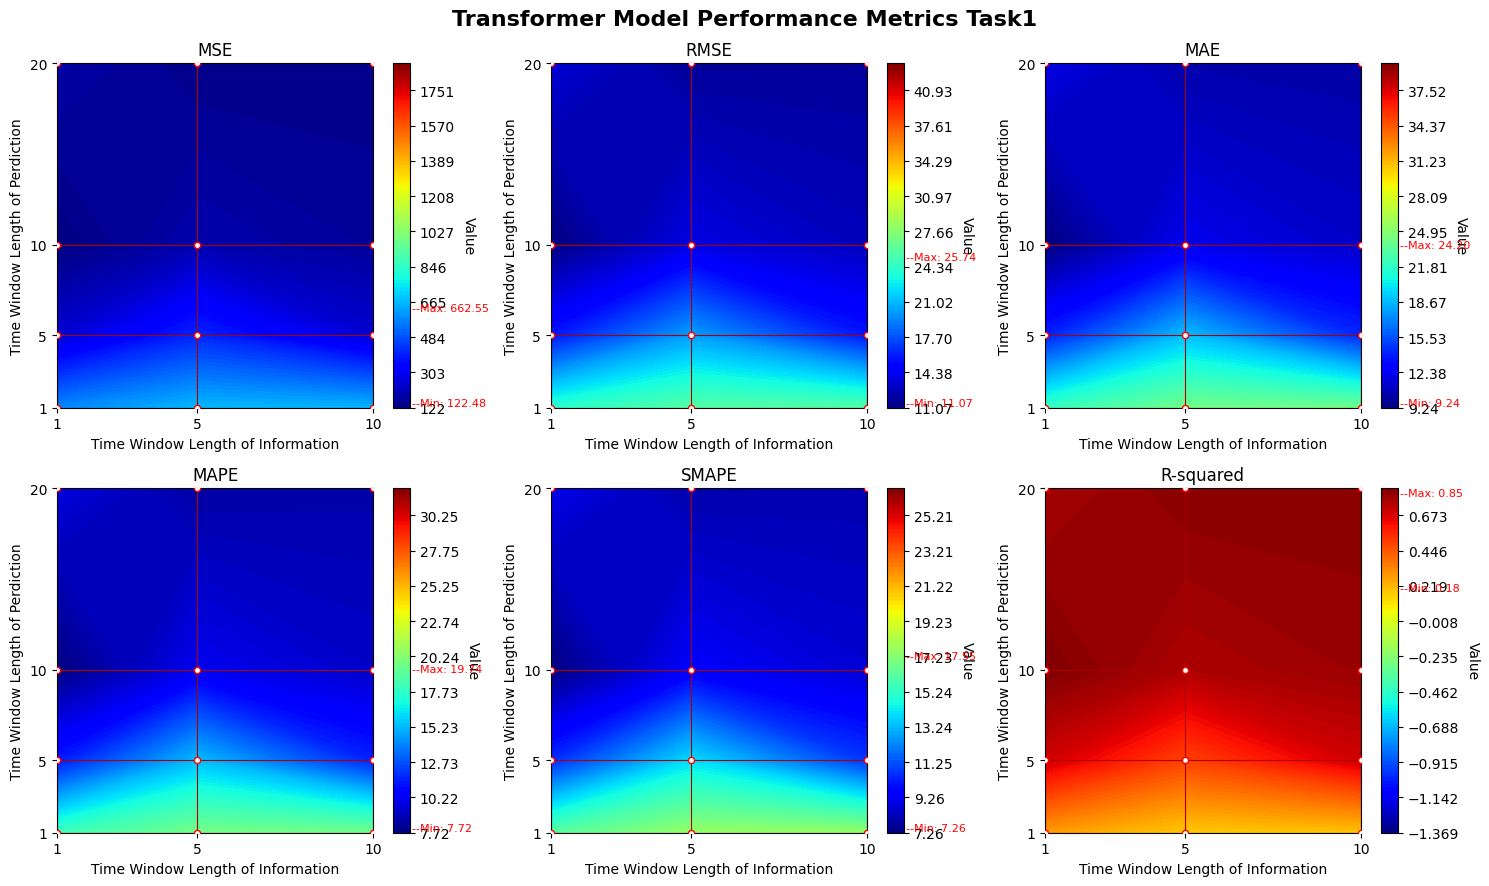

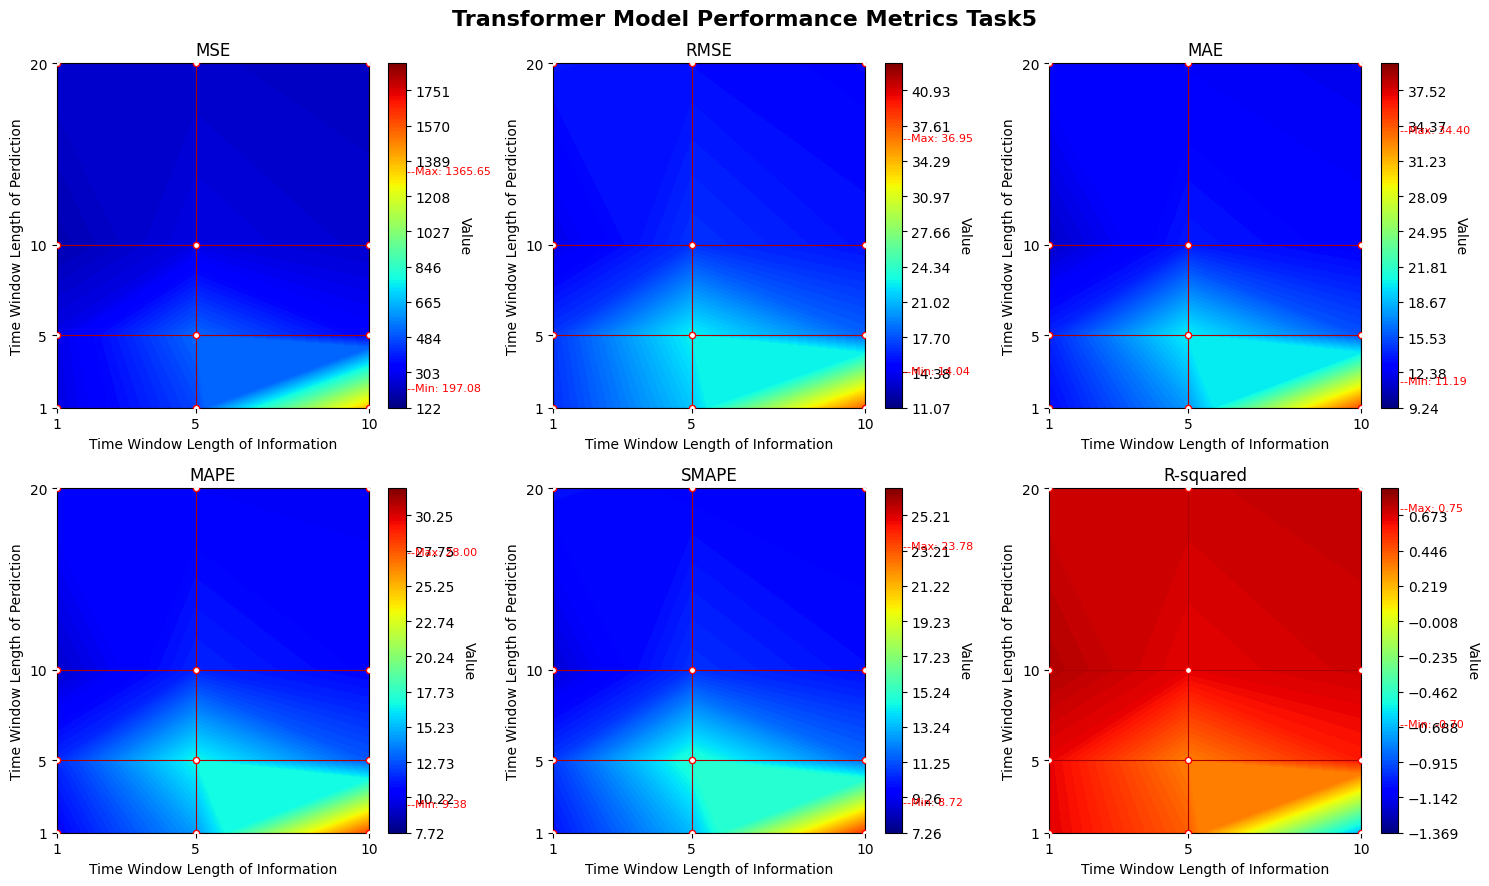

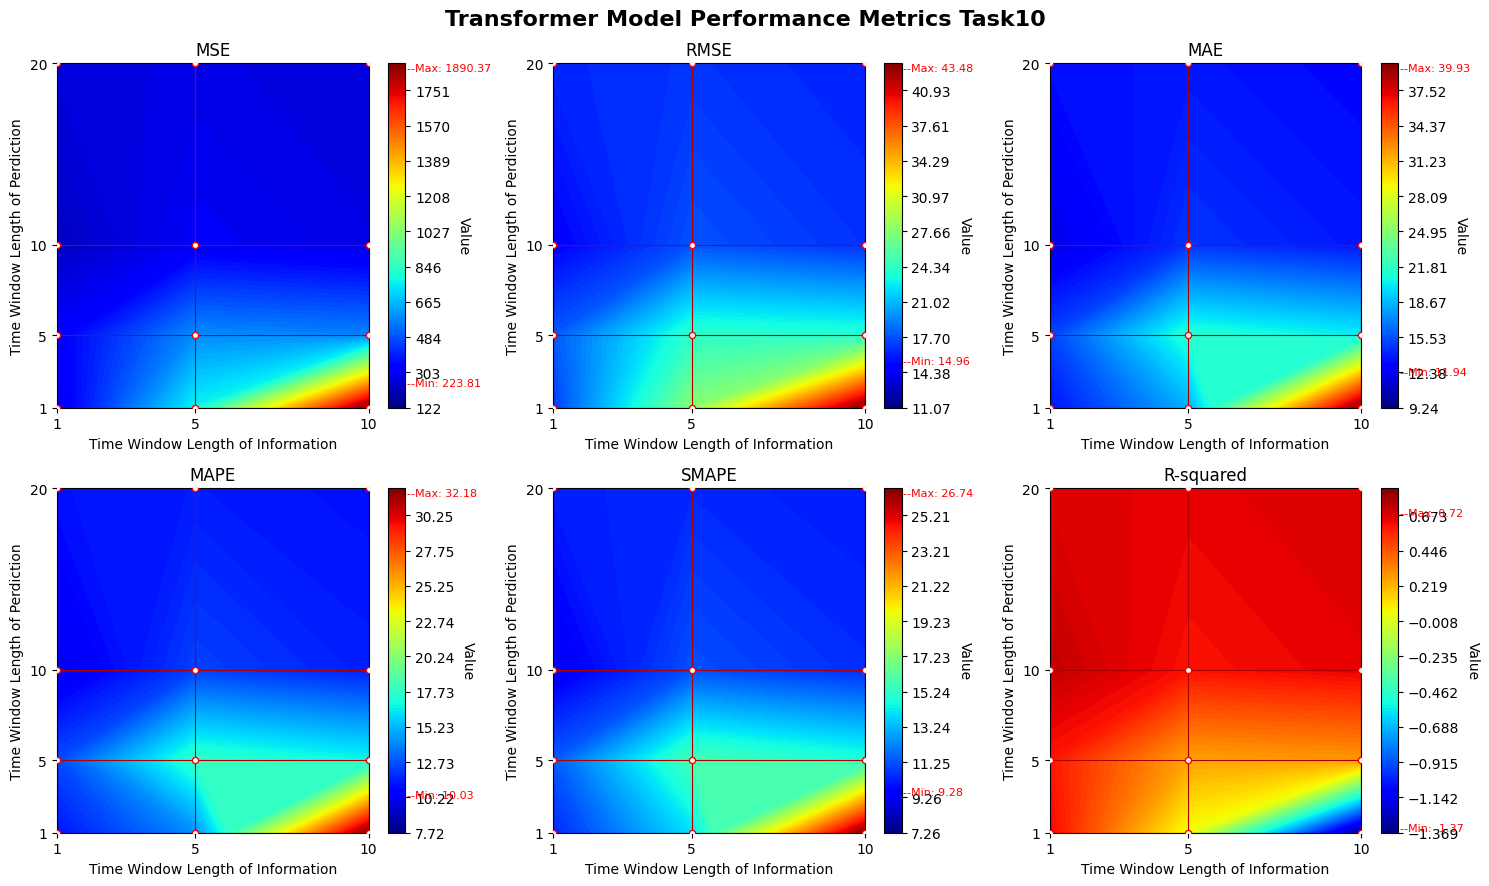

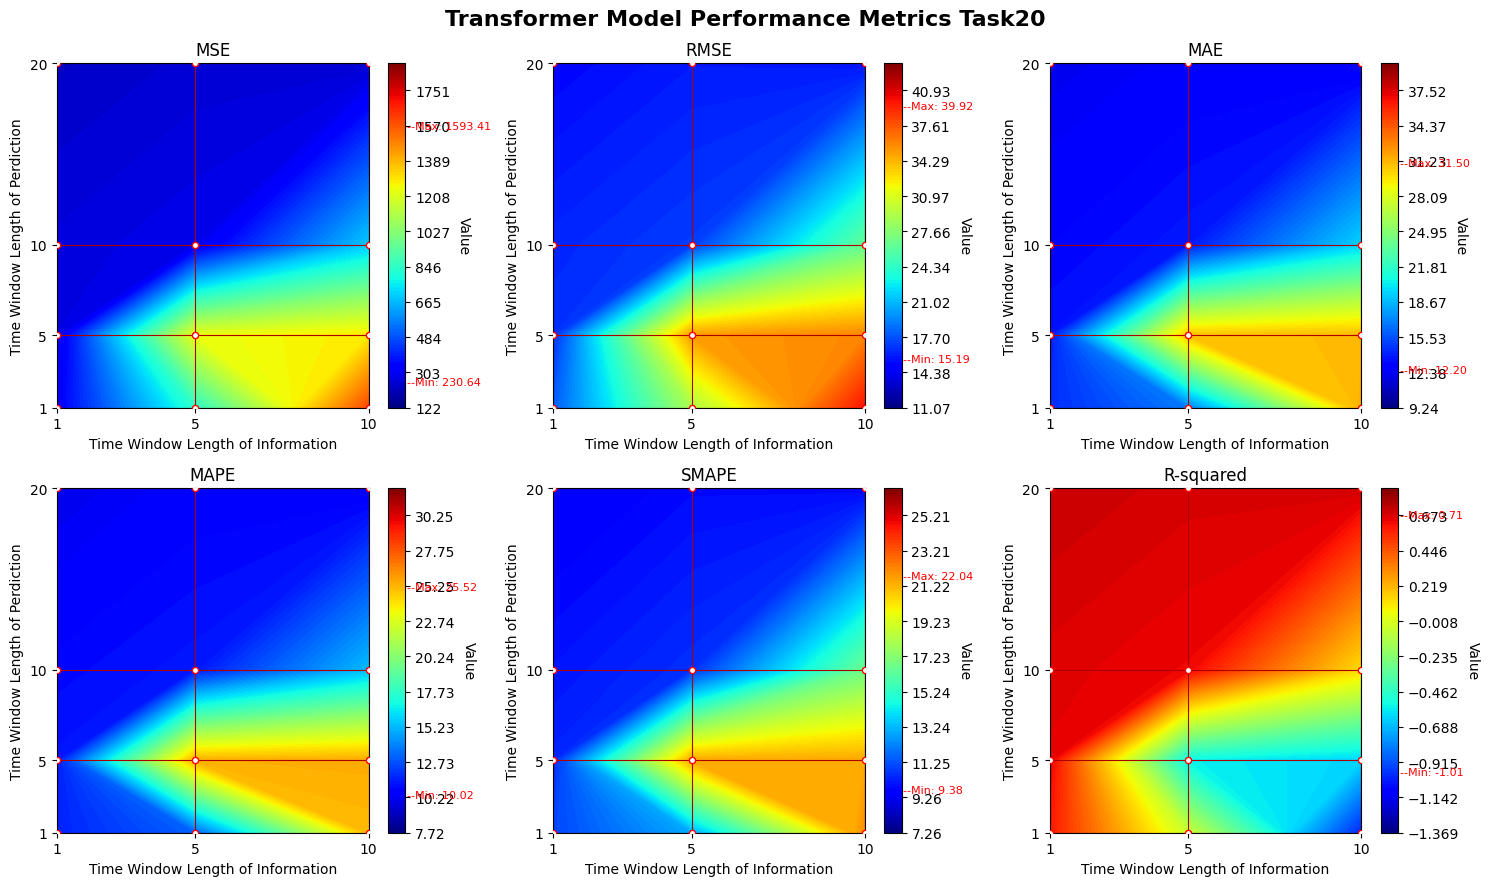

In [112]:
metrics_list = ["MSE", "RMSE", "MAE", "MAPE", "SMAPE", "R-squared"]

global_min = {metric: np.inf for metric in metrics_list}
global_max = {metric: -np.inf for metric in metrics_list}

# 计算每个指标的全局最小和最大值
for task in len_lst[1]:
    for x in len_lst[0]:
        for y in len_lst[1]:
            for metric in metrics_list:
                key = f'Transformer_{x}_{y}'
                value = metrics[f'{task}'][key][metric]
                if value < global_min[metric]:
                    global_min[metric] = value
                if value > global_max[metric]:
                    global_max[metric] = value

for task in len_lst[1]:
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 9), tight_layout=True)
    metrics_list = ["MSE", "RMSE", "MAE", "MAPE", "SMAPE", "R-squared"]
    fig.suptitle(f'Transformer Model Performance Metrics Task{task}', fontsize=16, fontweight='bold')

    for ax, metric_name in zip(axs.flatten(), metrics_list):
        
        Z = np.zeros((len(len_lst[0]), len(len_lst[1])))
        for i, x in enumerate(len_lst[0]):
            for j, y in enumerate(len_lst[1]):
                key = f'Transformer_{x}_{y}'
                Z[i, j] = metrics[f'{task}'][key][metric_name]

        X, Y = np.meshgrid(len_lst[1], len_lst[0])

        # print(metric_name,Z)
        
        levels = np.linspace(global_min[metric_name], global_max[metric_name], 128)
        contour = ax.contourf(Y, X, Z, levels=levels, cmap='jet')
        # contour = ax.contourf(Y, X, Z, levels=128, cmap='jet')
        cbar = fig.colorbar(contour, ax=ax, aspect = 10)
        cbar.set_label('Value', rotation=270, labelpad=20)

        cbar.outline.set_edgecolor('black')

        min_value = Z.min()
        max_value = Z.max()

        a = (Z.min()-global_min[metric_name])/(global_max[metric_name]-global_min[metric_name])
        b = (Z.max()-global_min[metric_name])/(global_max[metric_name]-global_min[metric_name]) 

        cbar.ax.text(0.5, a-0.015, f'{min_value:.2f}', transform=cbar.ax.transAxes, ha='center', va='top', fontsize=6, color = 'white')
        cbar.ax.text(0.5, b+0.01, f'{max_value:.2f}', transform=cbar.ax.transAxes, ha='center', va='bottom', fontsize=6, color = 'white')

        height = cbar.ax.get_position().height

        y_min = a * height
        y_max = b * height

        rectangle = Rectangle((0, a), 1, b-a, transform=cbar.ax.transAxes, linewidth=2, edgecolor='white', facecolor='none')
        cbar.ax.add_patch(rectangle)
        
        ax.set_title(metric_name)
        ax.set_xlabel('Time Window Length of Information')
        ax.set_ylabel('Time Window Length of Perdiction')
        ax.set_xticks(len_lst[0])
        ax.set_yticks(len_lst[1])
        ax.grid(True, linestyle='-', color='#AA0000')
        ax.scatter(Y.flatten(), X.flatten(), color='white', s=20, edgecolors='red', zorder=5)
        
    plt.savefig(f'Transformer_Model_Performance_Metrics_Task{task}.pdf')
    plt.show()

In [115]:

# 定义一个绘图函数
def plot_outputs(i):
    plt.figure(figsize=(10, 5))
    plt.plot(outputs_NN[i], color='red', label='NN Prediction')
    plt.plot(outputs_original[i], color='blue', label='Original Price')    
    plt.title(f"Output Comparison for Index {i}")
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.ylim(0,300)
    plt.legend()
    plt.grid(True)
    plt.show()

slider = IntSlider(min=0, max=len(outputs_NN)-1, step=1, value=0, description='Index:', 
                   layout=Layout(width='800px'))

interact(plot_outputs, i=slider)

interactive(children=(IntSlider(value=0, description='Index:', layout=Layout(width='800px'), max=99999), Outpu…

<function __main__.plot_outputs(i)>

array([[209.12616 , 199.53984 , 190.0894  , ..., 175.00833 , 174.47514 ,
        171.18517 ],
       [203.41493 , 195.78394 , 187.375   , ..., 175.13057 , 174.65793 ,
        171.41496 ],
       [214.9125  , 206.34033 , 197.22174 , ..., 184.0953  , 183.57552 ,
        180.11841 ],
       ...,
       [112.61034 , 114.58042 , 112.75704 , ..., 110.20637 , 110.37377 ,
        108.9538  ],
       [111.41429 , 113.704445, 112.05787 , ..., 109.97483 , 110.15427 ,
        108.75053 ],
       [112.19367 , 114.38994 , 112.68517 , ..., 110.43919 , 110.6113  ,
        109.19453 ]], dtype=float32)